In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# now define path to dataset
path="NewDataSet"
files=os.listdir(path)
# list of files in path
# sort path from A-Y
files.sort()

# print to see list
print(files)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [3]:
image_array=[]
label_array=[]
# loop through each file in files

for i in tqdm(range(len(files))):
	# list of image in each folder
	sub_file=os.listdir(path+"/"+files[i])
	# let's check length of each folder
	#	print(len(sub_file))

	# loop through each sub folder
	for j in range(len(sub_file)):

		# path of each image
		#Example:imagepro/A/image_name1.jpg

		file_path=path+"/"+files[i]+"/"+sub_file[j]
		# read each image

		image=cv2.imread(file_path)

		# resize image by 96x96
		image=cv2.resize(image,(224,224))
		# convert BGR image to RGB image
		image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

		# add this image at image_array
		image_array.append(image)

		# add label to label_array
		# i is number from 0 to len(files)-1
		# so we can use it as label
		label_array.append(i)

# save and run to see if it is working or not
# before that apply tqdm to for loop
# it is working with no errors

# convert list to array

image_array=np.array(image_array)
label_array=np.array(label_array,dtype="float")

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:22<00:00,  1.15it/s]


In [4]:
from sklearn.model_selection import train_test_split
# output									   train image   label      spliting size
X_train,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.2)

del image_array,label_array

# to free memory 
import gc
gc.collect()


# X_train will have 85% of images 
# X_test will have 15% of images

0

In [5]:
# Create a model

from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential, Model, load_model

model=Sequential()
# add pretrained models to Sequential model
# I will use EfficientNetB0 pretrained model. You can try different model.
pretrained_model=tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),include_top=False)

model.add(pretrained_model)

# add Pooling to model
model.add(layers.GlobalAveragePooling2D())

# add dropout to model
# We add dropout to increase accuracy by reduce overfitting
model.add(layers.Dropout(0.3))
# finally we will addd dense layer as an output
model.add(layers.Dense(1))
# For some tensorflow version we required to build model
model.build(input_shape=(None,224,224,3))


# to see model summary
model.summary()


# save and run to see model summary 
# make sure your pc is connected to internet to download pretrained weight
# It will take some time
# Everything till now works
# I am using GPU to train model so it will take 20-30 min.
# If you train model on CPU it will take some time


# compile model
# you can use different optimizer and loss function to increase accuracy
model.compile(optimizer="adam",loss="mae",metrics=["mae"])

# create a checkpoint to save best accuracy model
ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(
									filepath=ckp_path,
									monitor="val_mae",
									mode="auto",
									save_best_only=True,
									save_weights_only=True
									)
# monitor: monitor validation mae loss to save model
# mode: Use to save model when val_mae is minimum or maximum
# It has 3 option: "min","max","auto".
# for us you can select either "min" or "auto"
# When val_mae reduce model will be saved
# save_best_only: False -> It will save all model
# save_weights_only: Save only weight.


# create learning rate reducer to reduce lr when accuracy does not improve
# Correct 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
									factor=0.9,
									monitor="val_mae",
									mode="auto",
									cooldown=0,
									patience=5,
									verbose=1,
									min_lr=1e-6)

# factor: when it is reduce next lr will be 0.9 times of current
# next lr= 0.9* current lr

# patience=X
# reduce lr after X epoch when accuracy does not improve
# verbose : show it after every epoch

# min_lr : minimum learning rate 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [6]:
# Start training model
Epochs=100
Batch_Size=32
# Select batch size according to your Graphic card 
#
#X_train,X_test,Y_train,Y_test
history=model.fit(
				X_train,
				Y_train,
				validation_data=(X_test,Y_test),
				batch_size=Batch_Size,
				epochs=Epochs,
				callbacks=[model_checkpoint,reduce_lr]
				)

Epoch 1/100
196/196 [==============================] - 55s 229ms/step - loss: 2.8018 - mae: 2.8018 - val_loss: 2.3221 - val_mae: 2.3221 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 42s 215ms/step - loss: 1.3495 - mae: 1.3495 - val_loss: 0.6358 - val_mae: 0.6358 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 41s 212ms/step - loss: 1.0158 - mae: 1.0158 - val_loss: 1.1569 - val_mae: 1.1569 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 41s 211ms/step - loss: 0.8192 - mae: 0.8192 - val_loss: 0.8760 - val_mae: 0.8760 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 41s 211ms/step - loss: 0.7344 - mae: 0.7344 - val_loss: 0.7751 - val_mae: 0.7751 - lr: 0.0010
Epoch 6/100
196/196 [==============================] - 42s 215ms/step - loss: 0.6652 - mae: 0.6652 - val_loss: 0.5248 - val_mae: 0.5248 - lr: 0.0010
Epoch 7/100
196/196 [==============================] - 41s 212ms/step - loss: 0.6538 - mae: 0.6538 - val_l

Epoch 52/100
196/196 [==============================] - 43s 217ms/step - loss: 0.3769 - mae: 0.3769 - val_loss: 0.1842 - val_mae: 0.1842 - lr: 7.2900e-04
Epoch 53/100
196/196 [==============================] - 42s 216ms/step - loss: 0.3719 - mae: 0.3719 - val_loss: 0.1754 - val_mae: 0.1754 - lr: 7.2900e-04
Epoch 54/100
196/196 [==============================] - 43s 220ms/step - loss: 0.3553 - mae: 0.3553 - val_loss: 0.1414 - val_mae: 0.1414 - lr: 7.2900e-04
Epoch 55/100
196/196 [==============================] - 42s 215ms/step - loss: 0.3473 - mae: 0.3473 - val_loss: 0.1651 - val_mae: 0.1651 - lr: 7.2900e-04
Epoch 56/100
196/196 [==============================] - 42s 215ms/step - loss: 0.3812 - mae: 0.3812 - val_loss: 0.2357 - val_mae: 0.2357 - lr: 7.2900e-04
Epoch 57/100
196/196 [==============================] - 42s 216ms/step - loss: 0.3687 - mae: 0.3687 - val_loss: 0.1559 - val_mae: 0.1559 - lr: 7.2900e-04
Epoch 58/100
196/196 [==============================] - 42s 216ms/step - los

196/196 [==============================] - 42s 215ms/step - loss: 0.2870 - mae: 0.2870 - val_loss: 0.1227 - val_mae: 0.1227 - lr: 3.8742e-04
Epoch 100/100
196/196 [==============================] - 42s 215ms/step - loss: 0.2885 - mae: 0.2885 - val_loss: 0.1153 - val_mae: 0.1153 - lr: 3.8742e-04


dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


KeyError: 'val_accuracy'

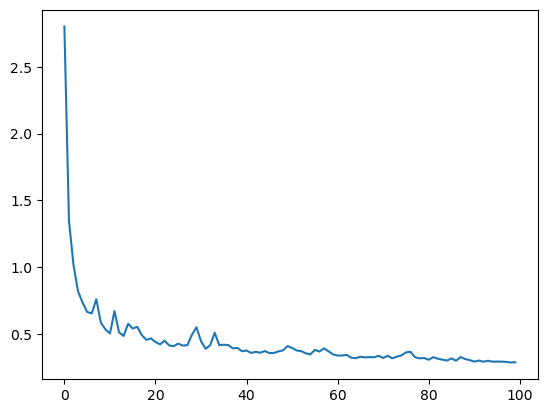

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Before training you can delete image_array and label_array to increase ram memory 

# Some error correction
# This code will be in the description so you can cross check everything
# Save and run 
# Everything is working

# after the training is done load best model

model.load_weights(ckp_path)

# convert model to tensorflow lite model

converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

# save model
with open("model2224.tflite","wb") as f:
	f.write(tflite_model)

# if you want to see prediction result on test dataset
prediction_val=model.predict(X_test,batch_size=32)

# print first 10 values
print(prediction_val[:10])
# print first 10 values of Y_test
print(Y_test[:10])

# Save and run this python file
# Before that I will show you
# loss: 0.4074 - mae: 0.4074 - val_loss: 0.3797 - val_mae: 0.3797
# we have mae and val_mae:
# mae: Is on X_train
# val_mae: X_test
# If val_mae is reducing that means your model is improving.

# I will show you the result after the training is over

#40/40 [==============================] - 8s 202ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0380 - val_mae: 0.0380 - lr: 2.5419e-04 (224 Input 5 Classes)
#196/196 [==============================] - 42s 215ms/step - loss: 0.2885 - mae: 0.2885 - val_loss: 0.1153 - val_mae: 0.1153 - lr: 3.8742e-04

INFO:tensorflow:Assets written to: C:\Users\safwa\AppData\Local\Temp\tmpbxzbwuwa\assets


INFO:tensorflow:Assets written to: C:\Users\safwa\AppData\Local\Temp\tmpbxzbwuwa\assets


49/49 [==============================] - 4s 53ms/step
[[10.013145  ]
 [13.959213  ]
 [21.05962   ]
 [11.012989  ]
 [13.883623  ]
 [ 9.0488205 ]
 [ 4.888017  ]
 [ 0.94989884]
 [ 8.97307   ]
 [19.87367   ]]
[10. 14. 21. 11. 14.  9.  5.  1.  9. 20.]
